In [2]:
from DeepPurpose import utils, dataset
from DeepPurpose import DTI as models
import warnings
warnings.filterwarnings("ignore")

## Part I: Overview of DeepPurpose and Data

Drug-target interaction measures the binding of drug molecules to the protein targets. Accurate identification of DTI is fundamental for drug discovery and supports many downstream tasks. Among others, drug screening and repurposing are two main applications based on DTI. Drug screening helps identify ligand candidates that can bind to the protein of interest, whereas drug repurposing finds new therapeutic purposes for existing drugs. Both tasks could alleviate the costly, time-consuming, and labor-intensive process of synthesis and analysis, which is extremely important, especially in the cases of hunting effective and safe treatments for COVID-19.

DeepPurpose is a pytorch-based deep learning framework that is initiated to provide a simple but powerful toolkit for drug-target interaction prediction and its related applications. We see many exciting recent works in this direction, but to leverage these models, it takes lots of efforts due to the esoteric instructions and interface. DeepPurpose is designed to make things as simple as possible using a unified framework.

DeepPurpose uses an encoder-decoder framework. Drug repurposing and screening are two applications after we obtain DTI models. The input to the model is a drug target pair, where drug uses the simplified molecular-input line-entry system (SMILES) string and target uses the amino acid sequence. The output is a score indicating the binding activity of the drug target pair. Now, we begin talking about the data format expected.


(**Data**) DeepPurpose takes into an array of drug's SMILES strings (**d**), an array of target protein's amino acid sequence (**t**), and an array of label (**y**), which can either be binary 0/1 indicating interaction outcome or a real number indicating affinity value. The input drug and target arrays should be paired, i.e. **y**\[0\] is the score for **d**\[0\] and **t**\[0\].

Besides transforming into numpy arrays through some data wrangling on your own, DeepPurpose also provides two ways to help data preparation. 

The first way is to read from local files. For example, to load drug target pairs, we expect a file.txt where each line is a drug SMILES string, followed by a protein sequence, and an affinity score or 0/1 label:

```CC1=C...C4)N MKK...LIDL 7.365``` \
```CC1=C...C4)N QQP...EGKH 4.999```

Then, we use ```dataset.read_file_training_dataset_drug_target_pairs``` to load it.

In [3]:
# Read the CSV
import pandas as pd
df = pd.read_csv('updated_drug_dataset.csv')

# Remove rows with NaN values
df_cleaned = df.dropna()

# # Extract the columns
# X_drugs = df_cleaned['canonical_smiles'].tolist()
# y = df_cleaned['class'].map(lambda x: 1 if x in ['active', 1] else 0).tolist()

# X_targets = df_cleaned['prot_amino_acid'].tolist()

# # Optional: Print how many rows were removed
# print(f"Original dataset size: {len(df)}")
# print(f"Cleaned dataset size: {len(df_cleaned)}")
# print(f"Number of rows removed: {len(df) - len(df_cleaned)}")
# print(X_drugs[0])
# print(X_targets[0])
# print(y[0])

In [4]:
def classify(value):
    if value >= 10000:
        return 0
    elif value <= 1000:
        return 1
    else:
        return None  # Keeps NaN for other values

# Apply classification function to create the new column
df_cleaned["class"] = df_cleaned["standard_value"].apply(classify)

# Save the updated dataset


print("Dataset updated with the new 'class' column!")

Dataset updated with the new 'class' column!


In [5]:
df_cleaned


,molecule_chembl_id,canonical_smiles,standard_value,protein,protein_sequence,protein_embedding,class
0,CHEMBL1828978,Cc1noc(C)c1-c1ccc2c(c1)CN(C)C(=O)N2,4800.0,BRD4,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,[-0.09784859 0.24607228 -0.02808847 ... -0.08...,NaN
1,CHEMBL1828979,Cc1noc(C)c1-c1ccccc1,84200.0,BRD4,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,[-0.09784859 0.24607228 -0.02808847 ... -0.08...,0.0
2,CHEMBL1828980,CC(=O)c1cccc(-c2c(C)noc2C)c1,24600.0,BRD4,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,[-0.09784859 0.24607228 -0.02808847 ... -0.08...,0.0
3,CHEMBL1828981,CCOc1cccc(-c2c(C)noc2C)c1,23200.0,BRD4,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,[-0.09784859 0.24607228 -0.02808847 ... -0.08...,0.0
4,CHEMBL1828982,Cc1noc(C)c1-c1cccc(C(C)O)c1,9700.0,BRD4,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,[-0.09784859 0.24607228 -0.02808847 ... -0.08...,NaN
...,...,...,...,...,...,...,...
54326,CHEMBL1527295,CCOC(=O)c1cnc2c(OC)cccc2c1N1CCN(c2ccccc2F)CC1,30000.0,mGluR5 (GRM5),MVLLLILSVLLLKEDVRGSAQSSERRVVAHMPGDIIIGALFSVHHQ...,[-0.15928867 0.11258257 0.02795647 ... -0.19...,0.0
54327,CHEMBL4751065,Cl.N[C@]1(C(=O)O)[C@@H]2[C@@H](C(=O)O)[C@@H]2[...,12500.0,mGluR5 (GRM5),MVLLLILSVLLLKEDVRGSAQSSERRVVAHMPGDIIIGALFSVHHQ...,[-0.15928867 0.11258257 0.02795647 ... -0.19...,0.0
54328,CHEMBL4758183,O=C1CCSC[C@@H](C(=O)Nc2cc(Cl)cc(Br)c2)N1,10000.0,mGluR5 (GRM5),MVLLLILSVLLLKEDVRGSAQSSERRVVAHMPGDIIIGALFSVHHQ...,[-0.15928867 0.11258257 0.02795647 ... -0.19...,0.0
54329,CHEMBL3955188,COc1ccc(-c2cc(C(N)=O)nc3cc(CCc4cnc(C)nc4)ccc23...,30000.0,mGluR5 (GRM5),MVLLLILSVLLLKEDVRGSAQSSERRVVAHMPGDIIIGALFSVHHQ...,[-0.15928867 0.11258257 0.02795647 ... -0.19...,0.0


In [6]:
filtered_df = df_cleaned.dropna(subset=["class"])

# Convert 'class' column to integer type (removes any potential issues with mixed types)
filtered_df["class"] = filtered_df["class"].astype(int)

# Count the number of 0s and 1s
class_counts = filtered_df["class"].value_counts()

# Display counts
print(class_counts)

class
1    29648
0    16702
Name: count, dtype: int64


In [7]:
X_drugs = filtered_df['canonical_smiles'].tolist()
y = filtered_df['class']
X_targets = filtered_df['protein_sequence'].tolist()

In [8]:
X_drugs

['Cc1noc(C)c1-c1ccccc1',
 'CC(=O)c1cccc(-c2c(C)noc2C)c1',
 'CCOc1cccc(-c2c(C)noc2C)c1',
 'CCOc1cc(C(=O)O)cc(-c2c(C)noc2C)c1',
 'CC(=O)c1cc(-c2ccccn2)c2ccccn12',
 'CN1Cc2cc(S(=O)(=O)N3CCOCC3)ccc2N(C)C1=O',
 'Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(C)n1-2',
 'Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(C)n1-2',
 'Cc1nnc2n1-c1ccccc1C(c1ccccc1)=N[C@H]2NC(=O)OCc1ccccc1',
 'CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C)nnc21',
 'Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C)(C)C)c1nnc(C)n1-2',
 'Cc1nnc2n1-c1ccccc1C(c1ccccc1)=NC2NC(=O)OCc1ccccc1',
 'CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n2c(C)nnc21',
 'CN1Cc2cc(NS(=O)(=O)c3ccccc3)ccc2NC1=O',
 'COc1ccc(S(=O)(=O)Nc2ccc3c(c2)CN(C)C(=O)N3)cc1',
 'COc1cccc(S(=O)(=O)Nc2ccc3c(c2)CN(C)C(=O)N3)c1',
 'CN1Cc2cc(NS(=O)(=O)c3ccccc3C(F)(F)F)ccc2NC1=O',
 'Cc1ccc(S(=O)(=O)Nc2ccc3c(c2)CN(C)C(=O)N3)cc1',
 'CN1Cc2cc(NS(=O)(=O)c3ccccc3F)ccc2NC1=O',
 'COc1ccccc1S(=O)(=O)Nc1ccc2c(c1)CN(C)C(=O)N2',
 'Cc1ccccc1S(=O)(=O)

In [9]:
y

1        0
2        0
3        0
6        0
10       0
        ..
54326    0
54327    0
54328    0
54329    0
54330    0
Name: class, Length: 46350, dtype: int64

In [10]:
X_targets

['MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICDPQALNDFLHGSEKIDGDDLLDSTG\nDAASAFFEGAGLHVQEPPGNHLSSEPSQPSASVDLDFLEDDILGSPGGAGGAEQPCDILQQSLQEANITE\nQTLEAEAELDLGSFQLPALQPVVPAPADGAAQIFPGGAADLLGLQPPAVLTHQALVQPSVGADVVNKAIS\nVQPFLQQVGLGNVTIQPISNLPGLPNGSPGGALGIGPIQVVGQQVMAINPPAQQLIAKPVQPSPVTAVPV\nGGYIAQPEQQQVALAASTGVSPQGAGLVIQKNLPAVATTTLNGSSVFGTQGSQPLTVTSNLSSPLVQAQN\nVIIHRTPTPIQPKPAGVLQQKLYQITPKPFAPNNATLTIQNEPALQPQKAQQQNLTFMAGKAGQNVVLSG\nFPQGLPANVFKQPPPQQQALSKPMSVHLLNQGSSIVIPAQHVPQAVLQGQNQFLLPGQLAGASAVPLTQQ\nLSALPANMGGQILATSHAGGQAHIIASQGPGGQLIANQALPAQILTNQNLAGPLNLGPVLTSPNAPGTAH\nILSAPIQVGQPALFQMPVSLAGGLSTQSQPAATSLGQTVIQGVTLPSQVAMLNAEGLAPAVSIQAPAASS\nQSPGLAQPQPPAPANLLSGAEQPILAVQSAPQPPAPLQLNVPPPAQPPGTPQPSPGMAASPEKIIAGAVI\nNQDSMQMFLQQVPQGIILQPKQPAPSSQGPPALAPPALAPFASPSSSASSSSVLGTQGQGQGQGQGQGQG\nQAPPGTGASAAPPATEPQTPVLPLLGIPAPLPAENKPFSGVSAPVSAAKGTAAPGKPGTPLAIQQTVPAK\nPGVISSVLAKGPVQIQVVGKLVPPLPNQPFDSKLKKTPTLQPSKEACFLEQLHKHQGSVLHPDYKTSFRS\nLEDALQRLLPYHVYQGVLPSPHDYRKVDEEFEVVSAQLLRRTQAMLNKYRLLLLEESRRVSP

In [11]:
drug_encoding, target_encoding = 'CNN', 'CNN'
# drug_encoding, target_encoding = 'Morgan', 'Conjoint_triad'

Note that you can switch encoder just by changing the encoding name above. The full list of encoders are listed [here](https://github.com/kexinhuang12345/DeepPurpose#encodings). Here, we are using the message passing neural network encoder for drug and convolutional neural network encoder for protein.

(**Data encoding and split**) Now, we encode the data into the specified format, using ```utils.data_process``` function. It specifies train/validation/test split fractions, and random seed to ensure same data splits for reproducibility. This function also support data splitting methods such as ```cold_drug``` and ```cold_protein```, which splits on drug/proteins for model robustness evaluation to test on unseen drug/proteins.

The function outputs train, val, test pandas dataframes.

In [13]:
# After data processing
train, val, test = utils.data_process(X_drugs, X_targets, y, 
                                      drug_encoding, target_encoding, 
                                      split_method='random', frac=[0.7, 0.1, 0.2],
                                      random_seed=1)

# Check for NaN values in the processed data
print("Checking for NaN values in training data:")
print(train.isna().sum())

print("Checking for NaN values in validation data:")
print(val.isna().sum())

print("Checking for NaN values in test data:")
print(test.isna().sum())

Drug Target Interaction Prediction Mode...
in total: 46350 drug-target pairs
encoding drug...
unique drugs: 32123
encoding protein...
unique target sequence: 34
splitting dataset...
Done.
Checking for NaN values in training data:
SMILES             0
Target Sequence    0
Label              0
drug_encoding      0
target_encoding    0
dtype: int64
Checking for NaN values in validation data:
SMILES             0
Target Sequence    0
Label              0
drug_encoding      0
target_encoding    0
dtype: int64
Checking for NaN values in test data:
SMILES             0
Target Sequence    0
Label              0
drug_encoding      0
target_encoding    0
dtype: int64


In [14]:
train

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,Cc1noc(C)c1-c1ccccc1,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,0,"[C, c, 1, n, o, c, (, C, ), c, 1, -, c, 1, c, ...","[M, C, R, C, L, A, G, S, C, L, R, S, P, C, G, ..."
1,CC(=O)c1cccc(-c2c(C)noc2C)c1,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,0,"[C, C, (, =, O, ), c, 1, c, c, c, c, (, -, c, ...","[M, C, R, C, L, A, G, S, C, L, R, S, P, C, G, ..."
2,CCOc1cccc(-c2c(C)noc2C)c1,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,0,"[C, C, O, c, 1, c, c, c, c, (, -, c, 2, c, (, ...","[M, C, R, C, L, A, G, S, C, L, R, S, P, C, G, ..."
3,CN1Cc2cc(S(=O)(=O)N3CCOCC3)ccc2N(C)C1=O,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,0,"[C, N, 1, C, c, 2, c, c, (, S, (, =, O, ), (, ...","[M, C, R, C, L, A, G, S, C, L, R, S, P, C, G, ..."
4,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,MCRCLAGSCLRSPCGDVWETPRRLLLKHHVDMDDEDGRCLLDVICD...,1,"[C, c, 1, s, c, 2, c, (, c, 1, C, ), C, (, c, ...","[M, C, R, C, L, A, G, S, C, L, R, S, P, C, G, ..."
...,...,...,...,...,...
32440,O=C(c1ccccc1)N1CCn2nc(-c3ccccc3)cc2C1,MVLLLILSVLLLKEDVRGSAQSSERRVVAHMPGDIIIGALFSVHHQ...,1,"[O, =, C, (, c, 1, c, c, c, c, c, 1, ), N, 1, ...","[M, V, L, L, L, I, L, S, V, L, L, L, K, E, D, ..."
32441,O=C1N[C@H](c2cncc(C#Cc3ccccc3)c2)[C@@H](c2c(F)...,MVLLLILSVLLLKEDVRGSAQSSERRVVAHMPGDIIIGALFSVHHQ...,1,"[O, =, C, 1, N, [, C, ?, H, ], (, c, 2, c, n, ...","[M, V, L, L, L, I, L, S, V, L, L, L, K, E, D, ..."
32442,O=C1CCSC[C@@H](C(=O)Nc2cc(Cl)cc(Br)c2)N1,MVLLLILSVLLLKEDVRGSAQSSERRVVAHMPGDIIIGALFSVHHQ...,0,"[O, =, C, 1, C, C, S, C, [, C, ?, ?, H, ], (, ...","[M, V, L, L, L, I, L, S, V, L, L, L, K, E, D, ..."
32443,COc1ccc(-c2cc(C(N)=O)nc3cc(CCc4cnc(C)nc4)ccc23...,MVLLLILSVLLLKEDVRGSAQSSERRVVAHMPGDIIIGALFSVHHQ...,0,"[C, O, c, 1, c, c, c, (, -, c, 2, c, c, (, C, ...","[M, V, L, L, L, I, L, S, V, L, L, L, K, E, D, ..."


(**Model configuration generation**) Now, we initialize a model with its configuration. You can modify almost any hyper-parameters (e.g., learning rate, epoch, batch size), model parameters (e.g. hidden dimensions, filter size) and etc in this function. The supported configurations are listed here in this [link](https://github.com/kexinhuang12345/DeepPurpose/blob/e169e2f550694145077bb2af95a4031abe400a77/DeepPurpose/utils.py#L486).

For the sake of example, we specify the epoch size to be 5, and set the model parameters to be small so that you can run on both CPUs & GPUs quickly and can proceed to the next steps. For a reference parameters, checkout the notebooks in the DEMO folder.

In [15]:

# use the parameters setting provided in the paper: https://arxiv.org/abs/1801.10193
config = utils.generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 5, 
                         LR = 0.001, 
                         batch_size = 256,
                         cnn_drug_filters = [32,64,96],
                         cnn_target_filters = [32,64,96],
                         cnn_drug_kernels = [4,6,8],
                         cnn_target_kernels = [4,8,12]
                        )

(**Model initialization**) Next, we initialize a model using the above configuration.

In [16]:
model = models.model_initialize(**config)
model

(**Model Training**) Next, it is ready to train, using the ```model.train``` function! If you do not have test set, you can just use ```model.train(train, val)```. 

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69206. Total time 0.00083 hours
Training at Epoch 1 iteration 100 with loss 0.38682. Total time 0.09333 hours
Validation at Epoch 1, AUROC: 0.92591 , AUPRC: 0.94872 , F1: 0.89566 , Cross-entropy Loss: 4.92246
Training at Epoch 2 iteration 0 with loss 0.31649. Total time 0.12638 hours
Training at Epoch 2 iteration 100 with loss 0.26885. Total time 0.22 hours
Validation at Epoch 2, AUROC: 0.94938 , AUPRC: 0.96675 , F1: 0.91087 , Cross-entropy Loss: 4.09039
Training at Epoch 3 iteration 0 with loss 0.26190. Total time 0.25 hours
Training at Epoch 3 iteration 100 with loss 0.24560. Total time 0.33305 hours
Validation at Epoch 3, AUROC: 0.95745 , AUPRC: 0.97190 , F1: 0.92253 , Cross-entropy Loss: 3.57714
Training at Epoch 4 iteration 0 with loss 0.23895. Total time 0.36805 hours
Training at Epoch 4 iteration 100 with loss 0.17377. Total time 0.45222 hours
Validation at Epoch 4, AURO

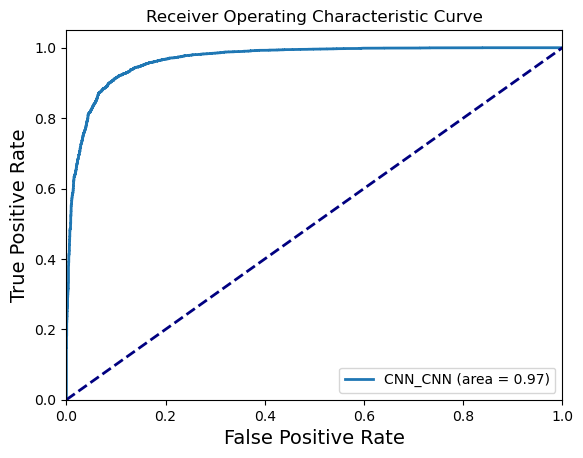

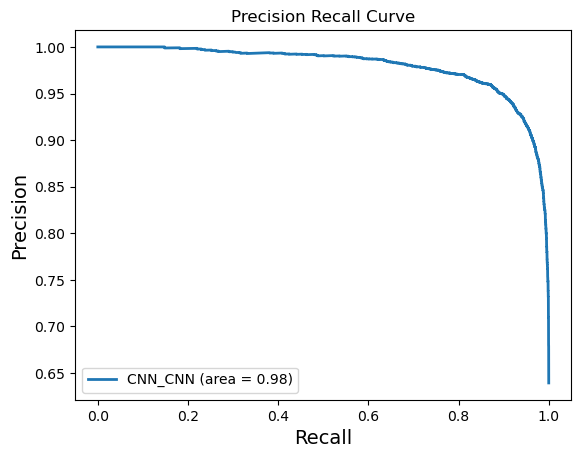

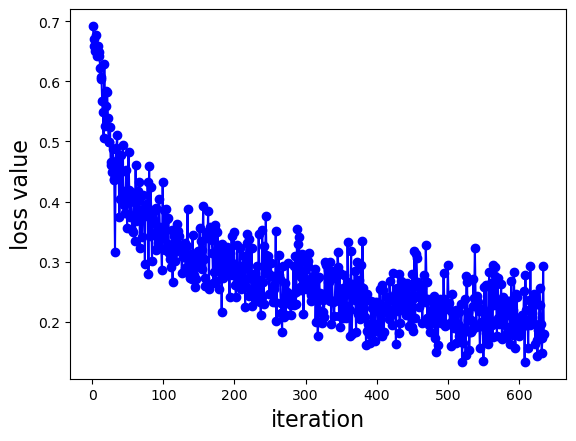

In [17]:
model.train(train, val, test)

In [1]:
import numpy as np
# Function to create aligned feature pairs
def create_feature_pairs(row, protein):

    return np.concatenate([row, protein])

# Apply function
combined = create_feature_pairs(X_drugs, X_targets)

NameError: name 'X_drugs' is not defined

In [39]:
! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.8/532.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 31.4 MB/s eta 0:00:00a 0:00:01


In [41]:
df["combined_features"] = df.apply(lambda row: create_feature_pairs(X_drugs, X_targets), axis=1)

NameError: name 'create_feature_pairs' is not defined

In [40]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(df["protein_sequence"].tolist())

shap.summary_plot(shap_values, df["protein_sequence"].tolist())


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <DeepPurpose.DTI.DBTA object at 0x3456f7b50>

In [ ]:
# Read the CSV
import pandas as pd
df = pd.read_csv('concatenated_dataset.csv')

# Remove rows with NaN values
df_cleaned = df.dropna()

# Extract the columns
X_drugs = df_cleaned['canonical_smiles'].tolist()
y = df_cleaned['class'].map(lambda x: 1 if x in ['active', 1] else 0).tolist()

X_targets = df_cleaned['prot_amino_acid'].tolist()

# Optional: Print how many rows were removed
print(f"Original dataset size: {len(df)}")
print(f"Cleaned dataset size: {len(df_cleaned)}")
print(f"Number of rows removed: {len(df) - len(df_cleaned)}")
print(X_drugs[0])
print(X_targets[0])
print(y[0])

Original dataset size: 10960
Cleaned dataset size: 10960
Number of rows removed: 0
CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(Cl)cc1
MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHPHFVIPYRCLVGEFVSDALLVPDKCKFLHQERMDVCETHLHWHTVAKETCSEKSTNLHDYGMLLPCGIDKFRGVEFVCCPLAEESDNVDSADAEEDDSDVWWGGADTDYADGSEDKVVEVAEEEEVAEVEEEEADDDEDDEDGDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSAMSQSLLKTTQEPLARDPVKLPTTAASTPDAVDKYLETPGDENEHAHFQKAKERLEAKHRERMSQVMREWEEAERQAKNLPKADKKAVIQHFQEKVESLEQEAANERQQLVETHMARVEAMLNDRRRLALENYITALQAVPPRPRHVFNMLKKYVRAEQKDRQHTLKHFEHVRMVDPKKAAQIRSQVMTHLRVIYERMNQSLSLLYNVPAVAEEIQDEVDELLQKEQNYSDDVLANMISEPRISYGNDALMPSLTETKTTVELLPVNGEFSLDDLQPWHSFGADSVPANTENEVEPVDARPAADRGLTTRPGSGLTNIKTEEISEVKMDAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIATVIVITLVMLKKKQYTSIHHGVVEVDAAVTPEERHLSKMQQNGYENPTYKFFEQMQN
0


We see that the model will automatically generate and plot the training process, along with the validation result and test result.

(**Model Prediction and Repuposing/Screening**) Next, we see how we can predict affinity scores on new data. Suppose the new data is a drug-target pair below.

In [9]:
X_drug = ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_target = ['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL']
y = [7.365]
X_pred = utils.data_process(X_drug, X_target, y, 
                                drug_encoding, target_encoding, 
                                split_method='no_split')
y_pred = model.predict(X_pred)
print('The predicted score is ' + str(y_pred))

in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
drug encoding finished...
encoding protein...
unique target sequence: 1
protein encoding finished...
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
The predicted score is [5.243870735168457]


We can also do repurposing and screening using the trained model. Basically, for repurposing a set of existing drugs (**r**) for a single new target (*t*), we run the above prediction function after pairing each repurposing drug with the target. Similarly, for screening, we instead have a set of drug-target pairs (**d**, **t**). We wrap the operation into a ```models.repurpose``` and ```models.virtual_screening``` methods.

For example, suppose we want to do repurposing from a set of antiviral drugs for a COVID-19 target 3CL protease. The corresponding data can be retrieved using ```dataset``` functions.


In [10]:
t, t_name = dataset.load_SARS_CoV2_Protease_3CL()
print('Target Name: ' + t_name)
print('Amino Acid Sequence: '+ t)

Target Name: SARS-CoV2 3CL Protease
Amino Acid Sequence: SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ


In [11]:
r, r_name, r_pubchem_cid = dataset.load_antiviral_drugs()
print('Repurposing Drug 1 Name: ' + r_name[0])
print('Repurposing Drug 1 SMILES: ' + r[0])
print('Repurposing Drug 1 Pubchem CID: ' + str(r_pubchem_cid[0]))

Repurposing Drug 1 Name: Abacavir
Repurposing Drug 1 SMILES: C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO
Repurposing Drug 1 Pubchem CID: 441300


Now, we can call the ```repurpose``` function. After feeding the necessary inputs, it will print a list of repurposed drugs ranked on its affinity to the target protein. The ```convert_y``` parameter should be set to be ```False``` when the ranking is ascending (i.e. lower value -> higher affinity) due to the log transformation, vice versus.

In [12]:
y_pred = models.repurpose(X_repurpose = r, target = t, model = model, drug_names = r_name, target_name = t_name, 
                          result_folder = "./result/", convert_y = True)

repurposing...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
drug encoding finished...
encoding protein...
unique target sequence: 1
protein encoding finished...
Done.
predicting...
---------------
Drug Repurposing Result for SARS-CoV2 3CL Protease
+------+----------------------+------------------------+---------------+
| Rank |      Drug Name       |      Target Name       | Binding Score |
+------+----------------------+------------------------+---------------+
|  1   |      Foscarnet       | SARS-CoV2 3CL Protease |      0.14     |
|  2   |      Efavirenz       | SARS-CoV2 3CL Protease |     20.86     |
|  3   |     Rimantadine      | SARS-CoV2 3CL Protease |     34.61     |
|  4   |      Sofosbuvir      | SARS-CoV2 3CL Protease |     81.58     |
|  5   |     Glecaprevir      | SARS-CoV2 3CL Protease |     83.02     |
|  6   |      Remdesivir      | SARS-CoV2 3CL Protease |     89.09     |
|  7   |     Grazoprevir      | SARS-CoV2 3CL Protease |     229.87    |
| 

Now, let's move on to showcase how to do virtual screening. We first load a sample of data from BindingDB dataset. 

In [13]:
t, d = dataset.load_IC50_1000_Samples()

Downloading...


We can then use the ```virtual_screening``` function to generate a list of drug-target pairs that have high binding affinities. If no drug/target names are provided, the index of the drug/target list is used instead.

In [14]:
y_pred = models.virtual_screening(d, t, model)

virtual screening...
in total: 100 drug-target pairs
encoding drug...
unique drugs: 100
drug encoding finished...
encoding protein...
unique target sequence: 93
protein encoding finished...
Done.
predicting...
---------------
Virtual Screening Result
+------+-----------+-------------+---------------+
| Rank | Drug Name | Target Name | Binding Score |
+------+-----------+-------------+---------------+
|  1   |  Drug 83  |  Target 83  |      8.87     |
|  2   |  Drug 53  |  Target 53  |      7.71     |
|  3   |  Drug 60  |  Target 60  |      7.01     |
|  4   |  Drug 41  |  Target 41  |      6.73     |
|  5   |  Drug 93  |  Target 93  |      6.59     |
|  6   |  Drug 32  |  Target 32  |      6.49     |
|  7   |   Drug 0  |   Target 0  |      6.43     |
|  8   |  Drug 64  |  Target 64  |      6.27     |
|  9   |  Drug 23  |  Target 23  |      6.26     |
|  10  |  Drug 21  |  Target 21  |      6.23     |
checkout ./result/virtual_screening.txt for the whole list



Saving and loading models are also really easy. The loading function also automatically detects if the model is trained on multiple GPUs. To save a model:

In [15]:
model.save_model('./tutorial_model')

To load a saved/pretrained model:

In [16]:
model = models.model_pretrained(path_dir = './tutorial_model')
model

We have also provided a list of pretrained model, you can find all available ones under the [list](https://github.com/kexinhuang12345/DeepPurpose#pretrained-models). For example, to load a MPNN+CNN model pretrained on BindingDB Kd dataset:

In [17]:
model = models.model_pretrained(model = 'MPNN_CNN_BindingDB')
model

Beginning Downloading MPNN_CNN_BindingDB Model...
pretrained model Successfully Downloaded...


We also provided many more functionalities for DTI research purposes. 

For example, this [demo](https://github.com/kexinhuang12345/DeepPurpose/blob/master/DEMO/Drug_Property_Pred-Ax-Hyperparam-Tune.ipynb) shows how to use Ax platform to do some latest hyperparameter tuning methods such as Bayesian Optimization on DeepPurpose.

Model robustness is very important for DTI task. One way to measure is to see how the model can predict drug or protein that do not exist in the training set, i.e., cold drug/target setting. You can achieve this by modifying the ```split_method``` parameter in the ```data_process``` function: 

In [18]:
X_drugs, X_targets, y = dataset.load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30)
train, val, test = utils.data_process(X_drugs, X_targets, y, 
                                drug_encoding, target_encoding, 
                                split_method='cold_drug',frac=[0.7,0.1,0.2],
                                random_seed = 1)

Beginning Processing...
Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
drug encoding finished...
encoding protein...
unique target sequence: 379
protein encoding finished...
splitting dataset...
Done.


That wraps up our tutorials on the main functionalities of DeepPurpose's Drug Target Interaction Prediction framework! 

Do checkout the upcoming tutorials:

Tutorial 2: Drug Property Prediction using DeepPurpose

Tutorial 3: Repurposing and Virtual Screening Using One Line of Code

**Star & watch & contribute to DeepPurpose's [github repository](https://github.com/kexinhuang12345/DeepPurpose)!**

Feedbacks would also be appreciated and you can send me an email (kexinhuang@hsph.harvard.edu)!